In [1]:
import cv2
import numpy as np
import os
# from matplotlib import pyplot as plt
import time
import mediapipe as mp


In [2]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities



In [3]:

def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results



In [4]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS) # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)

In [5]:
def draw_styled_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 



In [6]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
#     face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
#     lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
#     rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return pose



In [7]:
DATA_PATH = os.path.join('Yoga Dataset')

# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 20
 
# Specify the directory containing the UCF50 dataset.
DATASET_DIR = 'Yoga Dataset'
 
# Specify the list containing the names of the classes used for training. Feel free to choose any set of classes.
CLASSES_LIST =['Anjaneyasana', 'balasana', 'bhujangasana',
               'dandayamna bramanasana', 'druta utkatasana', 'kandharasana', 
               'padmasana', 'parvatasana', 'setuasana', 'shavasana', 'tadasana', 
               'ustrasana', 'vipareeta karaniasana', 'virbhadrasana', 'vrikshyasana']

In [8]:
print(os.listdir(DATASET_DIR))

['Anjaneyasana', 'balasana', 'bhujangasana', 'dandayamna bramanasana', 'druta utkatasana', 'kandharasana', 'padmasana', 'parvatasana', 'setuasana', 'shavasana', 'tadasana', 'ustrasana', 'vipareeta karaniasana', 'virbhadrasana', 'vrikshyasana']


In [9]:
import torch
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(LSTMModel, self).__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.lstm3 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, num_classes)
    
    def forward(self, x):
        out, _ = self.lstm1(x)
        out, _ = self.lstm2(out)
        out, _ = self.lstm3(out)
        out = out[:, -1, :]  # Take the last timestep's output
        out = torch.relu(self.fc1(out))
        out = torch.relu(self.fc2(out))
        out = self.fc3(out)
        return out


In [10]:
def frames_extraction(video_path):
    '''
    This function will extract the required frames from a video after resizing and normalizing them.
    Args:
        video_path: The path of the video in the disk, whose frames are to be extracted.
    Returns:
        frames_list: A list containing the resized and normalized frames of the video.
    '''
    with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    # Declare a list to store video frames.
        points_list = []
        
        # Read the Video File using the VideoCapture object.
        video_reader = cv2.VideoCapture(video_path)

        # Get the total number of frames in the video.
        video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
        #print(video_frames_count)
        # Calculate the the interval after which frames will be added to the list.
        skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

            # Iterate through the Video Frames.
        for frame_counter in range(SEQUENCE_LENGTH):

                # Set the current frame position of the video.
            video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
            #print(frame_counter * skip_frames_window)
                # Reading the frame from the video. 
            success, frame = video_reader.read()
            #print(success)


                # Check if Video frame is not successfully read then break the loop
            if not success:
                 break

            image ,result = mediapipe_detection(frame ,holistic)
            points =  extract_keypoints(result)
            #print(points)
            
            points_list.append(points)
        # Release the VideoCapture object. 
        video_reader.release()
 
    # Return the frames list.
    return np.asarray(points_list)






In [ ]:
x =frames_extraction('yoga/virbhadra/357551499_9427674887307361_3491618938100281147_n.mp4')

In [ ]:
x.shape

In [10]:
def create_dataset(output_path):
    features = []
    labels = []
    video_files_paths = []
    
    for class_index, class_name in enumerate(CLASSES_LIST):
        print(f'Extracting Data of Class: {class_name}')
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        for file_name in files_list:
            print(f'file name: {file_name}')
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)
            frames = frames_extraction(video_file_path)
            if len(frames) >= SEQUENCE_LENGTH:
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)
             
    features = np.asarray(features)
    labels = np.array(labels)  
    dataset = {
        'features': features,
        'labels': labels,
        'video_files_paths': video_files_paths
    }
    
    torch.save(dataset, output_path)
   
    
    return

In [ ]:
create_dataset('dataset.pth')

In [24]:
import torch

# Define the path to the dataset file
dataset_path = 'dataset.pth'

# Load the dataset
dataset = torch.load(dataset_path)
# print(dataset)# Access the dataset components
features = dataset['features']
labels = dataset['labels']
print(labels)

# Print the shapes of the loaded components

print("Features shape:", features.shape)
print("Labels shape:", labels.shape)



[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6
  6  6  6  6  6  6  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7
  7  7  7  7  7  7  7  7  7  7  7  7  7  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9  9  9  9
  9  9  9  9  9  9  9  9  9  9  9 10 10 10 10 10 10 10 10 10 10 10 10 10
 10 10 10 10 10 10 10 10 10 10 10 11 11 11 11 11 11 11 11 11 11 11 11 11
 11 11 11 11 11 11 11 11 11 11 11 11 12 12 12 12 12 12 12 12 12 12 12 12
 12 12 12 12 12 12 12 13 13 13 13 13 13 13 13 13 13

In [12]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt



In [13]:
import torch
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, file_path):
        self.data = torch.load(file_path)
        self.features = self.data['features']
        self.labels = self.data['labels']
        self.video_files_paths = self.data['video_files_paths']

    def __len__(self):
        return self.data['features'].shape[0]

    def __getitem__(self, index):
        feature = self.features[index]
        label = self.labels[index]
        video_path = self.video_files_paths[index]

        

        return feature, label, video_path

In [14]:
file_path = 'dataset.pth'
dataset = CustomDataset(file_path)



In [15]:
import torch
from torch.utils.data import DataLoader

# Define the path to the dataset file
dataset_path = 'dataset.pth'

# Create the custom dataset
dataset = CustomDataset(dataset_path)

# Define batch size and other data loader parameters
batch_size = 16
shuffle = True

# Create the data loader
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
x=0
# Iterate over the data loader
for batch in data_loader:
    # Unpack the batch
    batch_features, batch_labels, batch_video_paths = batch
   
   

    # Example: Print batch shapes
    print("Batch Features shape:", batch_features.shape)
    print("Batch Labels shape:", batch_labels)
    


Batch Features shape: torch.Size([16, 20, 132])
Batch Labels shape: tensor([ 0,  8, 14,  4,  0, 14,  3, 14,  2, 12,  9, 13,  9,  6,  6, 12],
       dtype=torch.int32)
Batch Features shape: torch.Size([16, 20, 132])
Batch Labels shape: tensor([ 3,  0,  5, 11,  3,  2,  8,  0,  9,  7,  9,  7,  8, 11,  1,  7],
       dtype=torch.int32)
Batch Features shape: torch.Size([16, 20, 132])
Batch Labels shape: tensor([ 9,  0,  8, 13, 13, 11,  2,  3,  3,  1,  3,  1, 13,  7, 11,  7],
       dtype=torch.int32)
Batch Features shape: torch.Size([16, 20, 132])
Batch Labels shape: tensor([ 8, 10,  6,  5, 14,  4,  5, 13,  2, 11, 14,  6,  8,  5,  1,  5],
       dtype=torch.int32)
Batch Features shape: torch.Size([16, 20, 132])
Batch Labels shape: tensor([ 7,  2,  3, 10,  4,  4,  8, 11, 12, 10, 14,  5, 12, 14,  6,  7],
       dtype=torch.int32)
Batch Features shape: torch.Size([16, 20, 132])
Batch Labels shape: tensor([ 5,  3,  6,  2,  8,  4,  4,  7, 10,  6, 13,  1, 12,  7,  3,  7],
       dtype=torch.int32

In [16]:
import torch
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(LSTMModel, self).__init__()
        
        self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True, bidirectional=False)
        self.dropout1 = nn.Dropout(0.2)
        
        self.lstm2 = nn.LSTM(hidden_size, hidden_size, batch_first=True, bidirectional=False)
        self.dropout2 = nn.Dropout(0.2)
        
        self.lstm3 = nn.LSTM(hidden_size, hidden_size, batch_first=True, bidirectional=False)
        
        self.fc1 = nn.Linear(hidden_size, 64)
        self.dropout3 = nn.Dropout(0.2)
        
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, num_classes)
        
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        out, _ = self.lstm1(x)
        out = self.dropout1(out)
        
        out, _ = self.lstm2(out)
        out = self.dropout2(out)
        
        out, _ = self.lstm3(out)
        
        out = self.fc1(out[:, -1, :])  # Select the last output of the last LSTM layer
        out = self.dropout3(out)
        
        out = self.fc2(out)
        out = self.fc3(out)
        
        out = self.softmax(out)
        
        return out

# Create an instance of the model
input_size = 132
hidden_size = 64
num_classes = 6
model = LSTMModel(input_size, hidden_size, num_classes)


In [ ]:
#yo test garna lai ho hai 

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter

# Define the necessary parameters for training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
learning_rate = 0.0001
num_epochs = 300
validation_split = 0.2  # 20% of the data will be used for validation

# Create an instance of the LSTM model
input_size = 132
hidden_size = 64
num_classes = 15
model = LSTMModel(input_size, hidden_size, num_classes).to(device)
model = model.float()  # Set the model parameters to float32

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Create the dataset
dataset_path = 'dataset.pth'
dataset = CustomDataset(dataset_path)

# Calculate the sizes for the training and validation sets
dataset_size = len(dataset)
validation_size = int(validation_split * dataset_size)
train_size = dataset_size - validation_size

# Split the dataset into training and validation sets
train_dataset, val_dataset = random_split(dataset, [train_size, validation_size])

# Create the data loaders for training and validation
batch_size = 4
shuffle = True
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Initialize TensorBoard writer
writer = SummaryWriter()

# Training loop
total_step = len(train_loader)
for epoch in range(num_epochs):
    model.train()  # Set the model to train mode
    train_loss = 0
    train_total = 0
    train_correct = 0

    for i, (features, labels, _) in enumerate(train_loader):
        # Move the data to the appropriate device (GPU or CPU)
        features = features.to(device).float()  # Set the features to float32
        labels = labels.to(device).long()  # Set the labels to torch.long

        # Forward pass
        outputs = model(features)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate training loss
        train_loss += loss.item() * features.size(0)
        _, train_predicted = torch.max(outputs.data, 1)

        # Accumulate training accuracy
        train_total += labels.size(0)
        train_correct += (train_predicted == labels).sum().item()

        # Print the training loss and accuracy every few iterations
        if (i+1) % 10 == 0:
            train_accuracy = 100 * train_correct / train_total
            train_loss /= train_total
            print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Train Accuracy: {:.2f}%'
                  .format(epoch+1, num_epochs, i+1, total_step, train_loss, train_accuracy))

            # Write to TensorBoard
            writer.add_scalar('Train Loss', train_loss, epoch * total_step + i)
            writer.add_scalar('Train Accuracy', train_accuracy, epoch * total_step + i)

    # Validation loop
    model.eval()  # Set the model to evaluation mode
    val_loss = 0
    val_total = 0
    val_correct = 0

    with torch.no_grad():
        for val_features, val_labels, _ in val_loader:
            val_features = val_features.to(device).float()  # Set the validation features to float32
            val_labels = val_labels.to(device).long()  # Set the validation labels to torch.long

            val_outputs = model(val_features)
            val_loss += criterion(val_outputs, val_labels).item() * val_features.size(0)
            _, val_predicted = torch.max(val_outputs.data, 1)
            val_total += val_labels.size(0)
            val_correct += (val_predicted == val_labels).sum().item()

    val_accuracy = 100 * val_correct / val_total
    val_loss /= val_total
    print('Epoch [{}/{}], Validation Loss: {:.4f}, Validation Accuracy: {:.2f}%'
          .format(epoch+1, num_epochs, val_loss, val_accuracy))

    # Write validation loss and accuracy to TensorBoard
    writer.add_scalar('Validation Loss', val_loss, epoch)
    writer.add_scalar('Validation Accuracy', val_accuracy, epoch)

# Save the final trained model
torch.save(model.state_dict(), 'trained_model_3.pth')

# Close the TensorBoard writer
writer.close()


Epoch [1/300], Step [10/72], Train Loss: 2.7070, Train Accuracy: 5.00%
Epoch [1/300], Step [20/72], Train Loss: 1.3880, Train Accuracy: 5.00%
Epoch [1/300], Step [30/72], Train Loss: 0.9142, Train Accuracy: 5.83%
Epoch [1/300], Step [40/72], Train Loss: 0.6823, Train Accuracy: 6.88%
Epoch [1/300], Step [50/72], Train Loss: 0.5450, Train Accuracy: 6.00%
Epoch [1/300], Step [60/72], Train Loss: 0.4537, Train Accuracy: 7.08%
Epoch [1/300], Step [70/72], Train Loss: 0.3884, Train Accuracy: 7.50%
Epoch [1/300], Validation Loss: 2.7084, Validation Accuracy: 7.04%
Epoch [2/300], Step [10/72], Train Loss: 2.7101, Train Accuracy: 2.50%
Epoch [2/300], Step [20/72], Train Loss: 1.3878, Train Accuracy: 6.25%
Epoch [2/300], Step [30/72], Train Loss: 0.9137, Train Accuracy: 8.33%
Epoch [2/300], Step [40/72], Train Loss: 0.6822, Train Accuracy: 10.00%
Epoch [2/300], Step [50/72], Train Loss: 0.5450, Train Accuracy: 9.50%
Epoch [2/300], Step [60/72], Train Loss: 0.4532, Train Accuracy: 10.00%
Epoch [2

Epoch [15/300], Step [50/72], Train Loss: 0.4953, Train Accuracy: 45.00%
Epoch [15/300], Step [60/72], Train Loss: 0.3911, Train Accuracy: 47.08%
Epoch [15/300], Step [70/72], Train Loss: 0.3471, Train Accuracy: 47.14%
Epoch [15/300], Validation Loss: 2.4534, Validation Accuracy: 38.03%
Epoch [16/300], Step [10/72], Train Loss: 2.4065, Train Accuracy: 47.50%
Epoch [16/300], Step [20/72], Train Loss: 1.2535, Train Accuracy: 43.75%
Epoch [16/300], Step [30/72], Train Loss: 0.8079, Train Accuracy: 45.00%
Epoch [16/300], Step [40/72], Train Loss: 0.5917, Train Accuracy: 46.88%
Epoch [16/300], Step [50/72], Train Loss: 0.4711, Train Accuracy: 48.00%
Epoch [16/300], Step [60/72], Train Loss: 0.4035, Train Accuracy: 47.50%
Epoch [16/300], Step [70/72], Train Loss: 0.3337, Train Accuracy: 49.29%
Epoch [16/300], Validation Loss: 2.4532, Validation Accuracy: 38.03%
Epoch [17/300], Step [10/72], Train Loss: 2.3826, Train Accuracy: 50.00%
Epoch [17/300], Step [20/72], Train Loss: 1.1608, Train Acc

Epoch [29/300], Step [70/72], Train Loss: 0.3353, Train Accuracy: 53.93%
Epoch [29/300], Validation Loss: 2.3450, Validation Accuracy: 47.89%
Epoch [30/300], Step [10/72], Train Loss: 2.2855, Train Accuracy: 55.00%
Epoch [30/300], Step [20/72], Train Loss: 1.1362, Train Accuracy: 57.50%
Epoch [30/300], Step [30/72], Train Loss: 0.7798, Train Accuracy: 56.67%
Epoch [30/300], Step [40/72], Train Loss: 0.5684, Train Accuracy: 56.88%
Epoch [30/300], Step [50/72], Train Loss: 0.4422, Train Accuracy: 58.00%
Epoch [30/300], Step [60/72], Train Loss: 0.3845, Train Accuracy: 57.08%
Epoch [30/300], Step [70/72], Train Loss: 0.3284, Train Accuracy: 56.43%
Epoch [30/300], Validation Loss: 2.3284, Validation Accuracy: 46.48%
Epoch [31/300], Step [10/72], Train Loss: 2.2393, Train Accuracy: 55.00%
Epoch [31/300], Step [20/72], Train Loss: 1.1280, Train Accuracy: 58.75%
Epoch [31/300], Step [30/72], Train Loss: 0.7068, Train Accuracy: 64.17%
Epoch [31/300], Step [40/72], Train Loss: 0.5466, Train Acc

Epoch [44/300], Step [10/72], Train Loss: 2.0227, Train Accuracy: 80.00%
Epoch [44/300], Step [20/72], Train Loss: 1.0840, Train Accuracy: 75.00%
Epoch [44/300], Step [30/72], Train Loss: 0.7161, Train Accuracy: 73.33%
Epoch [44/300], Step [40/72], Train Loss: 0.5340, Train Accuracy: 72.50%
Epoch [44/300], Step [50/72], Train Loss: 0.4251, Train Accuracy: 72.00%
Epoch [44/300], Step [60/72], Train Loss: 0.3514, Train Accuracy: 72.08%
Epoch [44/300], Step [70/72], Train Loss: 0.2975, Train Accuracy: 72.50%
Epoch [44/300], Validation Loss: 2.1311, Validation Accuracy: 69.01%
Epoch [45/300], Step [10/72], Train Loss: 2.0875, Train Accuracy: 75.00%
Epoch [45/300], Step [20/72], Train Loss: 1.0754, Train Accuracy: 73.75%
Epoch [45/300], Step [30/72], Train Loss: 0.7094, Train Accuracy: 73.33%
Epoch [45/300], Step [40/72], Train Loss: 0.5020, Train Accuracy: 76.25%
Epoch [45/300], Step [50/72], Train Loss: 0.4120, Train Accuracy: 76.50%
Epoch [45/300], Step [60/72], Train Loss: 0.3591, Train

Epoch [58/300], Step [30/72], Train Loss: 0.7052, Train Accuracy: 71.67%
Epoch [58/300], Step [40/72], Train Loss: 0.5735, Train Accuracy: 67.50%
Epoch [58/300], Step [50/72], Train Loss: 0.4458, Train Accuracy: 66.00%
Epoch [58/300], Step [60/72], Train Loss: 0.3563, Train Accuracy: 66.67%
Epoch [58/300], Step [70/72], Train Loss: 0.3152, Train Accuracy: 66.07%
Epoch [58/300], Validation Loss: 2.1565, Validation Accuracy: 66.20%
Epoch [59/300], Step [10/72], Train Loss: 2.0941, Train Accuracy: 72.50%
Epoch [59/300], Step [20/72], Train Loss: 1.1083, Train Accuracy: 68.75%
Epoch [59/300], Step [30/72], Train Loss: 0.7191, Train Accuracy: 69.17%
Epoch [59/300], Step [40/72], Train Loss: 0.5333, Train Accuracy: 69.38%
Epoch [59/300], Step [50/72], Train Loss: 0.4362, Train Accuracy: 68.50%
Epoch [59/300], Step [60/72], Train Loss: 0.3626, Train Accuracy: 67.92%
Epoch [59/300], Step [70/72], Train Loss: 0.3143, Train Accuracy: 67.14%
Epoch [59/300], Validation Loss: 2.1542, Validation Acc

Epoch [72/300], Step [50/72], Train Loss: 0.4217, Train Accuracy: 78.00%
Epoch [72/300], Step [60/72], Train Loss: 0.3382, Train Accuracy: 78.75%
Epoch [72/300], Step [70/72], Train Loss: 0.2816, Train Accuracy: 80.00%
Epoch [72/300], Validation Loss: 2.0457, Validation Accuracy: 77.46%
Epoch [73/300], Step [10/72], Train Loss: 1.9977, Train Accuracy: 82.50%
Epoch [73/300], Step [20/72], Train Loss: 1.0244, Train Accuracy: 82.50%
Epoch [73/300], Step [30/72], Train Loss: 0.6846, Train Accuracy: 81.67%
Epoch [73/300], Step [40/72], Train Loss: 0.4967, Train Accuracy: 82.50%
Epoch [73/300], Step [50/72], Train Loss: 0.4113, Train Accuracy: 81.50%
Epoch [73/300], Step [60/72], Train Loss: 0.3396, Train Accuracy: 81.25%
Epoch [73/300], Step [70/72], Train Loss: 0.2936, Train Accuracy: 80.36%
Epoch [73/300], Validation Loss: 2.0328, Validation Accuracy: 78.87%
Epoch [74/300], Step [10/72], Train Loss: 1.9763, Train Accuracy: 85.00%
Epoch [74/300], Step [20/72], Train Loss: 1.0579, Train Acc

Epoch [86/300], Step [70/72], Train Loss: 0.2747, Train Accuracy: 87.14%
Epoch [86/300], Validation Loss: 2.0644, Validation Accuracy: 77.46%
Epoch [87/300], Step [10/72], Train Loss: 1.8984, Train Accuracy: 95.00%
Epoch [87/300], Step [20/72], Train Loss: 1.0459, Train Accuracy: 86.25%
Epoch [87/300], Step [30/72], Train Loss: 0.6912, Train Accuracy: 83.33%
Epoch [87/300], Step [40/72], Train Loss: 0.5331, Train Accuracy: 80.00%
Epoch [87/300], Step [50/72], Train Loss: 0.4082, Train Accuracy: 80.00%
Epoch [87/300], Step [60/72], Train Loss: 0.3476, Train Accuracy: 79.17%
Epoch [87/300], Step [70/72], Train Loss: 0.2739, Train Accuracy: 81.07%
Epoch [87/300], Validation Loss: 2.0183, Validation Accuracy: 81.69%
Epoch [88/300], Step [10/72], Train Loss: 1.9814, Train Accuracy: 85.00%
Epoch [88/300], Step [20/72], Train Loss: 1.0086, Train Accuracy: 85.00%
Epoch [88/300], Step [30/72], Train Loss: 0.6542, Train Accuracy: 86.67%
Epoch [88/300], Step [40/72], Train Loss: 0.5231, Train Acc

Epoch [101/300], Step [10/72], Train Loss: 1.9146, Train Accuracy: 90.00%
Epoch [101/300], Step [20/72], Train Loss: 1.0205, Train Accuracy: 86.25%
Epoch [101/300], Step [30/72], Train Loss: 0.6647, Train Accuracy: 85.83%
Epoch [101/300], Step [40/72], Train Loss: 0.4961, Train Accuracy: 85.62%
Epoch [101/300], Step [50/72], Train Loss: 0.4110, Train Accuracy: 84.00%
Epoch [101/300], Step [60/72], Train Loss: 0.3181, Train Accuracy: 85.42%
Epoch [101/300], Step [70/72], Train Loss: 0.2787, Train Accuracy: 85.71%
Epoch [101/300], Validation Loss: 1.9982, Validation Accuracy: 81.69%
Epoch [102/300], Step [10/72], Train Loss: 1.9931, Train Accuracy: 82.50%
Epoch [102/300], Step [20/72], Train Loss: 1.0353, Train Accuracy: 81.25%
Epoch [102/300], Step [30/72], Train Loss: 0.6487, Train Accuracy: 84.17%
Epoch [102/300], Step [40/72], Train Loss: 0.5204, Train Accuracy: 81.88%
Epoch [102/300], Step [50/72], Train Loss: 0.3864, Train Accuracy: 83.50%
Epoch [102/300], Step [60/72], Train Loss:

Epoch [115/300], Step [10/72], Train Loss: 1.8680, Train Accuracy: 95.00%
Epoch [115/300], Step [20/72], Train Loss: 1.0074, Train Accuracy: 90.00%
Epoch [115/300], Step [30/72], Train Loss: 0.6312, Train Accuracy: 91.67%
Epoch [115/300], Step [40/72], Train Loss: 0.4958, Train Accuracy: 90.00%
Epoch [115/300], Step [50/72], Train Loss: 0.3860, Train Accuracy: 90.00%
Epoch [115/300], Step [60/72], Train Loss: 0.3212, Train Accuracy: 90.00%
Epoch [115/300], Step [70/72], Train Loss: 0.2964, Train Accuracy: 87.86%
Epoch [115/300], Validation Loss: 1.9464, Validation Accuracy: 87.32%
Epoch [116/300], Step [10/72], Train Loss: 1.9924, Train Accuracy: 82.50%
Epoch [116/300], Step [20/72], Train Loss: 0.9835, Train Accuracy: 86.25%
Epoch [116/300], Step [30/72], Train Loss: 0.6307, Train Accuracy: 89.17%
Epoch [116/300], Step [40/72], Train Loss: 0.5081, Train Accuracy: 86.88%
Epoch [116/300], Step [50/72], Train Loss: 0.3761, Train Accuracy: 88.50%
Epoch [116/300], Step [60/72], Train Loss:

Epoch [129/300], Step [10/72], Train Loss: 1.9162, Train Accuracy: 90.00%
Epoch [129/300], Step [20/72], Train Loss: 0.9826, Train Accuracy: 90.00%
Epoch [129/300], Step [30/72], Train Loss: 0.6556, Train Accuracy: 89.17%
Epoch [129/300], Step [40/72], Train Loss: 0.5145, Train Accuracy: 86.25%
Epoch [129/300], Step [50/72], Train Loss: 0.3909, Train Accuracy: 86.50%
Epoch [129/300], Step [60/72], Train Loss: 0.3211, Train Accuracy: 87.08%
Epoch [129/300], Step [70/72], Train Loss: 0.2821, Train Accuracy: 86.79%
Epoch [129/300], Validation Loss: 1.9466, Validation Accuracy: 87.32%
Epoch [130/300], Step [10/72], Train Loss: 1.8912, Train Accuracy: 92.50%
Epoch [130/300], Step [20/72], Train Loss: 1.0071, Train Accuracy: 88.75%
Epoch [130/300], Step [30/72], Train Loss: 0.6891, Train Accuracy: 85.00%
Epoch [130/300], Step [40/72], Train Loss: 0.4771, Train Accuracy: 86.88%
Epoch [130/300], Step [50/72], Train Loss: 0.3858, Train Accuracy: 87.50%
Epoch [130/300], Step [60/72], Train Loss:

Epoch [143/300], Step [10/72], Train Loss: 1.9661, Train Accuracy: 85.00%
Epoch [143/300], Step [20/72], Train Loss: 1.0085, Train Accuracy: 85.00%
Epoch [143/300], Step [30/72], Train Loss: 0.6391, Train Accuracy: 87.50%
Epoch [143/300], Step [40/72], Train Loss: 0.4893, Train Accuracy: 87.50%
Epoch [143/300], Step [50/72], Train Loss: 0.3859, Train Accuracy: 88.00%
Epoch [143/300], Step [60/72], Train Loss: 0.3376, Train Accuracy: 86.67%
Epoch [143/300], Step [70/72], Train Loss: 0.2786, Train Accuracy: 86.79%
Epoch [143/300], Validation Loss: 1.9440, Validation Accuracy: 87.32%
Epoch [144/300], Step [10/72], Train Loss: 1.8676, Train Accuracy: 95.00%
Epoch [144/300], Step [20/72], Train Loss: 1.0069, Train Accuracy: 90.00%
Epoch [144/300], Step [30/72], Train Loss: 0.6392, Train Accuracy: 90.83%
Epoch [144/300], Step [40/72], Train Loss: 0.4963, Train Accuracy: 89.38%
Epoch [144/300], Step [50/72], Train Loss: 0.3908, Train Accuracy: 89.00%
Epoch [144/300], Step [60/72], Train Loss:

Epoch [157/300], Step [10/72], Train Loss: 1.9386, Train Accuracy: 87.50%
Epoch [157/300], Step [20/72], Train Loss: 0.9718, Train Accuracy: 90.00%
Epoch [157/300], Step [30/72], Train Loss: 0.6799, Train Accuracy: 86.67%
Epoch [157/300], Step [40/72], Train Loss: 0.5023, Train Accuracy: 85.62%
Epoch [157/300], Step [50/72], Train Loss: 0.4010, Train Accuracy: 85.00%
Epoch [157/300], Step [60/72], Train Loss: 0.3172, Train Accuracy: 86.25%
Epoch [157/300], Step [70/72], Train Loss: 0.2751, Train Accuracy: 86.79%
Epoch [157/300], Validation Loss: 1.9494, Validation Accuracy: 87.32%
Epoch [158/300], Step [10/72], Train Loss: 1.8420, Train Accuracy: 97.50%
Epoch [158/300], Step [20/72], Train Loss: 0.9940, Train Accuracy: 92.50%
Epoch [158/300], Step [30/72], Train Loss: 0.6721, Train Accuracy: 89.17%
Epoch [158/300], Step [40/72], Train Loss: 0.4898, Train Accuracy: 88.75%
Epoch [158/300], Step [50/72], Train Loss: 0.3959, Train Accuracy: 88.00%
Epoch [158/300], Step [60/72], Train Loss:

Epoch [171/300], Step [10/72], Train Loss: 1.9122, Train Accuracy: 90.00%
Epoch [171/300], Step [20/72], Train Loss: 0.9665, Train Accuracy: 92.50%
Epoch [171/300], Step [30/72], Train Loss: 0.6374, Train Accuracy: 92.50%
Epoch [171/300], Step [40/72], Train Loss: 0.4901, Train Accuracy: 91.25%
Epoch [171/300], Step [50/72], Train Loss: 0.3805, Train Accuracy: 91.50%
Epoch [171/300], Step [60/72], Train Loss: 0.3189, Train Accuracy: 91.67%
Epoch [171/300], Step [70/72], Train Loss: 0.2774, Train Accuracy: 91.07%
Epoch [171/300], Validation Loss: 1.8927, Validation Accuracy: 92.96%
Epoch [172/300], Step [10/72], Train Loss: 1.9513, Train Accuracy: 87.50%
Epoch [172/300], Step [20/72], Train Loss: 0.9991, Train Accuracy: 87.50%
Epoch [172/300], Step [30/72], Train Loss: 0.6560, Train Accuracy: 87.50%
Epoch [172/300], Step [40/72], Train Loss: 0.4771, Train Accuracy: 88.75%
Epoch [172/300], Step [50/72], Train Loss: 0.3720, Train Accuracy: 90.50%
Epoch [172/300], Step [60/72], Train Loss:

Epoch [185/300], Step [10/72], Train Loss: 1.8673, Train Accuracy: 95.00%
Epoch [185/300], Step [20/72], Train Loss: 0.9726, Train Accuracy: 93.75%
Epoch [185/300], Step [30/72], Train Loss: 0.6393, Train Accuracy: 93.33%
Epoch [185/300], Step [40/72], Train Loss: 0.4770, Train Accuracy: 93.12%
Epoch [185/300], Step [50/72], Train Loss: 0.3710, Train Accuracy: 94.00%
Epoch [185/300], Step [60/72], Train Loss: 0.3226, Train Accuracy: 93.33%
Epoch [185/300], Step [70/72], Train Loss: 0.2802, Train Accuracy: 92.50%
Epoch [185/300], Validation Loss: 1.8740, Validation Accuracy: 94.37%
Epoch [186/300], Step [10/72], Train Loss: 1.9262, Train Accuracy: 90.00%
Epoch [186/300], Step [20/72], Train Loss: 0.9455, Train Accuracy: 93.75%
Epoch [186/300], Step [30/72], Train Loss: 0.6549, Train Accuracy: 91.67%
Epoch [186/300], Step [40/72], Train Loss: 0.4715, Train Accuracy: 92.50%
Epoch [186/300], Step [50/72], Train Loss: 0.3859, Train Accuracy: 92.00%
Epoch [186/300], Step [60/72], Train Loss:

Epoch [199/300], Step [10/72], Train Loss: 1.9919, Train Accuracy: 82.50%
Epoch [199/300], Step [20/72], Train Loss: 1.0579, Train Accuracy: 78.75%
Epoch [199/300], Step [30/72], Train Loss: 0.6809, Train Accuracy: 79.17%
Epoch [199/300], Step [40/72], Train Loss: 0.5709, Train Accuracy: 73.12%
Epoch [199/300], Step [50/72], Train Loss: 0.4111, Train Accuracy: 74.00%
Epoch [199/300], Step [60/72], Train Loss: 0.3502, Train Accuracy: 73.75%
Epoch [199/300], Step [70/72], Train Loss: 0.2991, Train Accuracy: 73.57%
Epoch [199/300], Validation Loss: 1.9872, Validation Accuracy: 83.10%
Epoch [200/300], Step [10/72], Train Loss: 1.9901, Train Accuracy: 82.50%
Epoch [200/300], Step [20/72], Train Loss: 1.0203, Train Accuracy: 82.50%
Epoch [200/300], Step [30/72], Train Loss: 0.7240, Train Accuracy: 77.50%
Epoch [200/300], Step [40/72], Train Loss: 0.5153, Train Accuracy: 77.50%
Epoch [200/300], Step [50/72], Train Loss: 0.3970, Train Accuracy: 79.00%
Epoch [200/300], Step [60/72], Train Loss:

Epoch [213/300], Step [10/72], Train Loss: 1.9648, Train Accuracy: 85.00%
Epoch [213/300], Step [20/72], Train Loss: 1.0003, Train Accuracy: 86.25%
Epoch [213/300], Step [30/72], Train Loss: 0.6751, Train Accuracy: 85.00%
Epoch [213/300], Step [40/72], Train Loss: 0.4900, Train Accuracy: 85.62%
Epoch [213/300], Step [50/72], Train Loss: 0.4107, Train Accuracy: 84.00%
Epoch [213/300], Step [60/72], Train Loss: 0.3205, Train Accuracy: 85.00%
Epoch [213/300], Step [70/72], Train Loss: 0.2821, Train Accuracy: 85.00%
Epoch [213/300], Validation Loss: 1.9425, Validation Accuracy: 87.32%
Epoch [214/300], Step [10/72], Train Loss: 1.9417, Train Accuracy: 87.50%
Epoch [214/300], Step [20/72], Train Loss: 1.0202, Train Accuracy: 85.00%
Epoch [214/300], Step [30/72], Train Loss: 0.6480, Train Accuracy: 86.67%
Epoch [214/300], Step [40/72], Train Loss: 0.5082, Train Accuracy: 85.00%
Epoch [214/300], Step [50/72], Train Loss: 0.4009, Train Accuracy: 84.50%
Epoch [214/300], Step [60/72], Train Loss:

Epoch [227/300], Step [10/72], Train Loss: 1.9909, Train Accuracy: 82.50%
Epoch [227/300], Step [20/72], Train Loss: 0.9710, Train Accuracy: 87.50%
Epoch [227/300], Step [30/72], Train Loss: 0.6718, Train Accuracy: 85.83%
Epoch [227/300], Step [40/72], Train Loss: 0.4962, Train Accuracy: 85.62%
Epoch [227/300], Step [50/72], Train Loss: 0.3966, Train Accuracy: 85.50%
Epoch [227/300], Step [60/72], Train Loss: 0.3291, Train Accuracy: 85.42%
Epoch [227/300], Step [70/72], Train Loss: 0.2820, Train Accuracy: 85.36%
Epoch [227/300], Validation Loss: 1.9739, Validation Accuracy: 84.51%
Epoch [228/300], Step [10/72], Train Loss: 1.9270, Train Accuracy: 90.00%
Epoch [228/300], Step [20/72], Train Loss: 1.0607, Train Accuracy: 82.50%
Epoch [228/300], Step [30/72], Train Loss: 0.6906, Train Accuracy: 80.83%
Epoch [228/300], Step [40/72], Train Loss: 0.5337, Train Accuracy: 78.12%
Epoch [228/300], Step [50/72], Train Loss: 0.4072, Train Accuracy: 78.50%
Epoch [228/300], Step [60/72], Train Loss:

Epoch [241/300], Step [10/72], Train Loss: 1.9660, Train Accuracy: 85.00%
Epoch [241/300], Step [20/72], Train Loss: 1.0082, Train Accuracy: 85.00%
Epoch [241/300], Step [30/72], Train Loss: 0.6640, Train Accuracy: 85.00%
Epoch [241/300], Step [40/72], Train Loss: 0.4900, Train Accuracy: 85.62%
Epoch [241/300], Step [50/72], Train Loss: 0.4058, Train Accuracy: 84.50%
Epoch [241/300], Step [60/72], Train Loss: 0.3255, Train Accuracy: 85.00%
Epoch [241/300], Step [70/72], Train Loss: 0.2679, Train Accuracy: 86.43%
Epoch [241/300], Validation Loss: 1.9298, Validation Accuracy: 88.73%
Epoch [242/300], Step [10/72], Train Loss: 1.9419, Train Accuracy: 87.50%
Epoch [242/300], Step [20/72], Train Loss: 1.0076, Train Accuracy: 86.25%
Epoch [242/300], Step [30/72], Train Loss: 0.6726, Train Accuracy: 85.00%
Epoch [242/300], Step [40/72], Train Loss: 0.5021, Train Accuracy: 84.38%
Epoch [242/300], Step [50/72], Train Loss: 0.3809, Train Accuracy: 86.00%
Epoch [242/300], Step [60/72], Train Loss:

Epoch [255/300], Step [10/72], Train Loss: 1.9671, Train Accuracy: 85.00%
Epoch [255/300], Step [20/72], Train Loss: 1.0203, Train Accuracy: 83.75%
Epoch [255/300], Step [30/72], Train Loss: 0.6514, Train Accuracy: 85.83%
Epoch [255/300], Step [40/72], Train Loss: 0.4724, Train Accuracy: 88.12%
Epoch [255/300], Step [50/72], Train Loss: 0.3714, Train Accuracy: 90.00%
Epoch [255/300], Step [60/72], Train Loss: 0.3320, Train Accuracy: 88.75%
Epoch [255/300], Step [70/72], Train Loss: 0.2786, Train Accuracy: 88.57%
Epoch [255/300], Validation Loss: 1.8870, Validation Accuracy: 92.96%
Epoch [256/300], Step [10/72], Train Loss: 1.8707, Train Accuracy: 95.00%
Epoch [256/300], Step [20/72], Train Loss: 0.9571, Train Accuracy: 95.00%
Epoch [256/300], Step [30/72], Train Loss: 0.6303, Train Accuracy: 95.00%
Epoch [256/300], Step [40/72], Train Loss: 0.4770, Train Accuracy: 94.38%
Epoch [256/300], Step [50/72], Train Loss: 0.3862, Train Accuracy: 93.50%
Epoch [256/300], Step [60/72], Train Loss:

Epoch [269/300], Step [10/72], Train Loss: 1.9406, Train Accuracy: 87.50%
Epoch [269/300], Step [20/72], Train Loss: 1.0002, Train Accuracy: 87.50%
Epoch [269/300], Step [30/72], Train Loss: 0.6684, Train Accuracy: 85.83%
Epoch [269/300], Step [40/72], Train Loss: 0.5538, Train Accuracy: 80.00%
Epoch [269/300], Step [50/72], Train Loss: 0.4060, Train Accuracy: 80.00%
Epoch [269/300], Step [60/72], Train Loss: 0.3232, Train Accuracy: 81.67%
Epoch [269/300], Step [70/72], Train Loss: 0.2929, Train Accuracy: 81.07%
Epoch [269/300], Validation Loss: 1.9555, Validation Accuracy: 85.92%
Epoch [270/300], Step [10/72], Train Loss: 1.9519, Train Accuracy: 87.50%
Epoch [270/300], Step [20/72], Train Loss: 0.9865, Train Accuracy: 88.75%
Epoch [270/300], Step [30/72], Train Loss: 0.6744, Train Accuracy: 85.83%
Epoch [270/300], Step [40/72], Train Loss: 0.4890, Train Accuracy: 86.25%
Epoch [270/300], Step [50/72], Train Loss: 0.4028, Train Accuracy: 85.50%
Epoch [270/300], Step [60/72], Train Loss:

Epoch [283/300], Step [10/72], Train Loss: 1.8417, Train Accuracy: 97.50%
Epoch [283/300], Step [20/72], Train Loss: 0.9686, Train Accuracy: 95.00%
Epoch [283/300], Step [30/72], Train Loss: 0.6550, Train Accuracy: 92.50%
Epoch [283/300], Step [40/72], Train Loss: 0.4877, Train Accuracy: 91.25%
Epoch [283/300], Step [50/72], Train Loss: 0.3807, Train Accuracy: 91.50%
Epoch [283/300], Step [60/72], Train Loss: 0.3210, Train Accuracy: 91.25%
Epoch [283/300], Step [70/72], Train Loss: 0.2643, Train Accuracy: 92.14%
Epoch [283/300], Validation Loss: 1.8861, Validation Accuracy: 92.96%
Epoch [284/300], Step [10/72], Train Loss: 1.9163, Train Accuracy: 90.00%
Epoch [284/300], Step [20/72], Train Loss: 0.9817, Train Accuracy: 90.00%
Epoch [284/300], Step [30/72], Train Loss: 0.6388, Train Accuracy: 90.83%
Epoch [284/300], Step [40/72], Train Loss: 0.4950, Train Accuracy: 89.38%
Epoch [284/300], Step [50/72], Train Loss: 0.3882, Train Accuracy: 89.50%
Epoch [284/300], Step [60/72], Train Loss:

Epoch [297/300], Step [10/72], Train Loss: 1.8667, Train Accuracy: 95.00%
Epoch [297/300], Step [20/72], Train Loss: 0.9685, Train Accuracy: 93.75%
Epoch [297/300], Step [30/72], Train Loss: 0.6548, Train Accuracy: 91.67%
Epoch [297/300], Step [40/72], Train Loss: 0.4894, Train Accuracy: 90.62%
Epoch [297/300], Step [50/72], Train Loss: 0.3760, Train Accuracy: 91.50%
Epoch [297/300], Step [60/72], Train Loss: 0.3086, Train Accuracy: 92.50%
Epoch [297/300], Step [70/72], Train Loss: 0.2713, Train Accuracy: 92.50%
Epoch [297/300], Validation Loss: 1.8723, Validation Accuracy: 94.37%
Epoch [298/300], Step [10/72], Train Loss: 1.8668, Train Accuracy: 95.00%
Epoch [298/300], Step [20/72], Train Loss: 0.9692, Train Accuracy: 93.75%
Epoch [298/300], Step [30/72], Train Loss: 0.6550, Train Accuracy: 91.67%
Epoch [298/300], Step [40/72], Train Loss: 0.4770, Train Accuracy: 91.88%
Epoch [298/300], Step [50/72], Train Loss: 0.3856, Train Accuracy: 91.50%
Epoch [298/300], Step [60/72], Train Loss:

In [22]:
!pip install scikit-learn


                                              0.0/9.3 MB ? eta -:--:--
                                              0.0/9.3 MB ? eta -:--:--
                                              0.0/9.3 MB 217.9 kB/s eta 0:00:43
                                              0.0/9.3 MB 217.9 kB/s eta 0:00:43
                                              0.1/9.3 MB 273.8 kB/s eta 0:00:34
                                              0.1/9.3 MB 350.1 kB/s eta 0:00:27
                                              0.2/9.3 MB 525.1 kB/s eta 0:00:18
                                              0.2/9.3 MB 599.0 kB/s eta 0:00:16
     -                                        0.3/9.3 MB 681.0 kB/s eta 0:00:14
     -                                        0.5/9.3 MB 972.0 kB/s eta 0:00:10
     --                                       0.5/9.3 MB 994.4 kB/s eta 0:00:09
     ---                                      0.7/9.3 MB 1.3 MB/s eta 0:00:07
     ----                                     1.0/9.3 MB 1.7

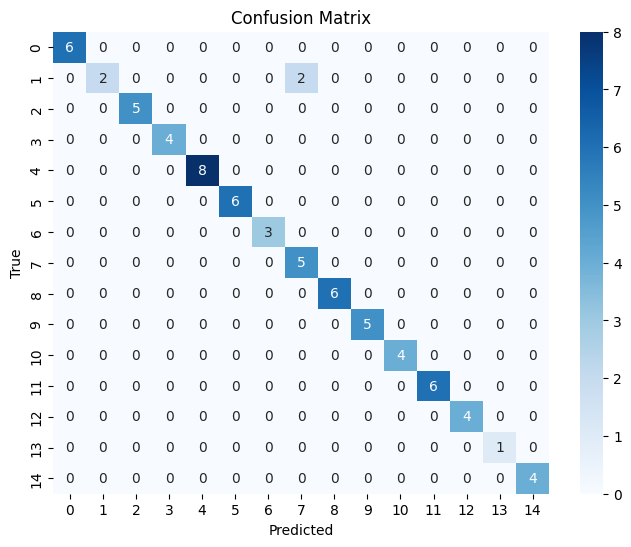

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from torch.utils.data import DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter

# Define class names in the order of their corresponding indices


# ... (rest of the code for training and validation)

# After training the model and calculating validation accuracy, create a list to store predicted labels and ground truth labels
predicted_labels = []
ground_truth_labels = []

# Set the model to evaluation mode
model.eval()

# Disable gradient computation
with torch.no_grad():
    for val_features, val_labels, _ in val_loader:
        val_features = val_features.to(device).float()  # Set the validation features to float32
        val_labels = val_labels.to(device).long()  # Set the validation labels to torch.long

        val_outputs = model(val_features)
        _, val_predicted = torch.max(val_outputs.data, 1)

        # Append predicted labels and ground truth labels to the lists
        predicted_labels.extend(val_predicted.cpu().numpy())
        ground_truth_labels.extend(val_labels.cpu().numpy())

# Create the confusion matrix



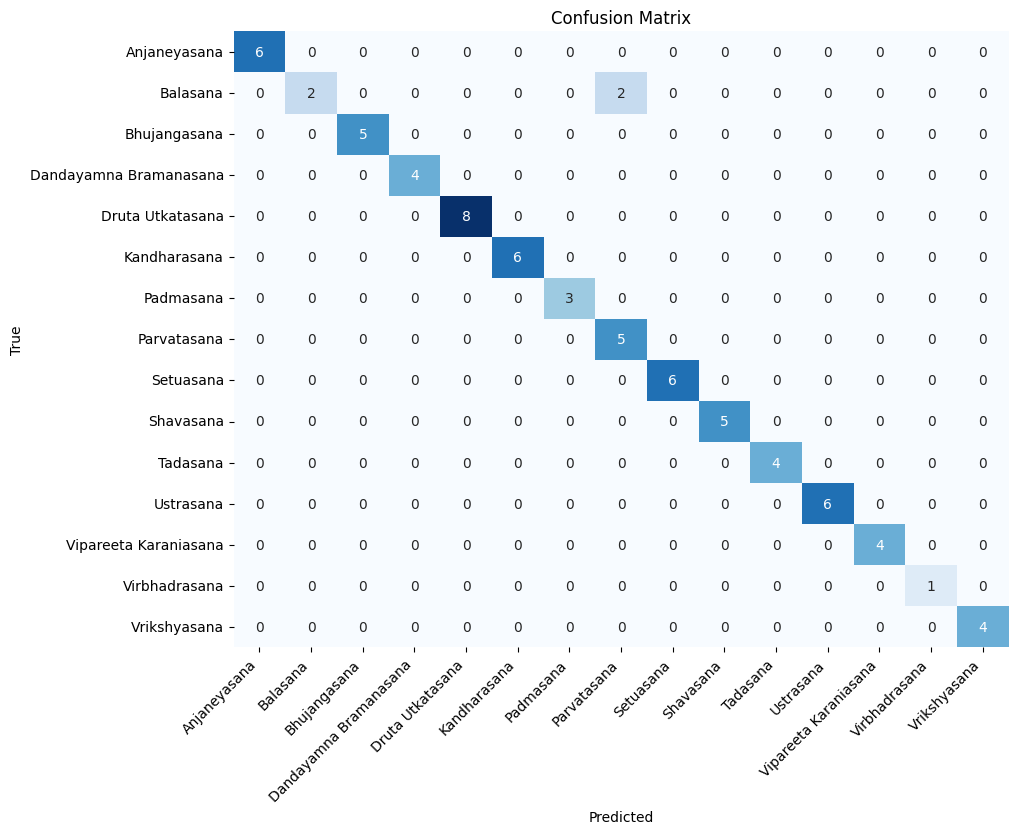

In [27]:
class_names = ['Anjaneyasana', 'Balasana', 'Bhujangasana', 'Dandayamna Bramanasana',
               'Druta Utkatasana', 'Kandharasana', 'Padmasana', 'Parvatasana', 
               'Setuasana', 'Shavasana', 'Tadasana', 'Ustrasana', 
               'Vipareeta Karaniasana', 'Virbhadrasana', 'Vrikshyasana']
cm = confusion_matrix(ground_truth_labels, predicted_labels)

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(10, 8))  # Increase figure size to accommodate rotated labels
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names, cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

# Rotate the x-axis and y-axis labels by 45 degrees
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0, va='center')

plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# Define the necessary parameters for training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
learning_rate = 0.001
num_epochs = 10

# Create an instance of the LSTM model
input_size = 132
hidden_size = 64
num_classes = 6
model = LSTMModel(input_size, hidden_size, num_classes).to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Create the data loader
dataset_path = 'dataset.pth'
dataset = CustomDataset(dataset_path)
batch_size = 32
shuffle = True
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

# Training loop
total_step = len(data_loader)
for epoch in range(num_epochs):
    for i, (features, labels, _) in enumerate(data_loader):
        # Move the data to the appropriate device (GPU or CPU)
        features = features.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(features)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print the loss every few iterations
        if (i+1) % 10 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                  .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

# Save the trained model
torch.save(model.state_dict(), 'trained_model.pth')


In [ ]:
#yo bhanda tala ko main ho 

In [ ]:
import torch
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(LSTMModel, self).__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.lstm3 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, num_classes)
    
    def forward(self, x):
        out, _ = self.lstm1(x)
        out, _ = self.lstm2(out)
        out, _ = self.lstm3(out)
        out = out[:, -1, :]  # Take the last timestep's output
        out = out.squeeze(1)  # Remove the extra dimension
        out = torch.relu(self.fc1(out))
        out = torch.relu(self.fc2(out))
        out = self.fc3(out)
        return out

# Define hyperparameters and paths
dataset_path = 'dataset.pth'
batch_size = 32
num_epochs = 10
input_size = 132  # Input size of each timestep
hidden_size = 64  # Number of hidden units in the LSTM layers
num_classes = 6

# Set the default data type to float64 for the entire PyTorch environment
torch.set_default_dtype(torch.float64)

# Create an instance of the VideoDataset
dataset = CustomDataset(dataset_path)

# Create a DataLoader for batching and shuffling the dataset
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Create an instance of the LSTMModel and convert the model parameters to float64
model = LSTMModel(input_size, hidden_size, num_classes)
model = model.to(torch.float64)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(num_epochs):
    for frames, labels in dataloader:
        frames = frames.to(torch.float64)  # Convert input data to float64
        labels = labels.to(torch.int64)  # Convert labels to int64 (if they are not already)

        # Reshape the input tensor
        batch_size, seq_length, num_features = frames.size()
        frames = frames.view(batch_size * seq_length, num_features)

        # Forward pass
        outputs = model(frames)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print training progress
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')

# Save the trained model
torch.save(model.state_dict(), 'trained_model.pth')


In [ ]:
features = np.expand_dims(features, axis=-1)

In [ ]:
Y_true = labels

In [ ]:
one_hot_encoded_labels = to_categorical(labels)

In [ ]:
one_hot_encoded_labels

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.2, shuffle = True)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard




In [ ]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import TensorBoard

In [ ]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(20,132)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(6, activation='softmax'))

In [ ]:
from tensorflow.keras.layers import Dropout

model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(20,132)))
model.add(Dropout(0.2))  # add dropout after first LSTM layer
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(Dropout(0.2))  # add dropout after second LSTM layer
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))  # add dropout after dense layer
model.add(Dense(32, activation='relu'))
model.add(Dense(6, activation='softmax'))

In [ ]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [ ]:
from tensorflow.keras.optimizers import Adam


lr = 0.0001

In [ ]:
#early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)
model.compile(optimizer=Adam(lr=lr), loss='categorical_crossentropy', metrics=['accuracy'])


        
        
    

In [ ]:
history = model.fit(X_train, y_train, epochs=200,batch_size=4, callbacks=[tb_callback])

In [ ]:
X_train.shape


In [ ]:

model_evaluation_history = model.evaluate(X_test,y_test)



In [ ]:
def plot_metric(model_training_history, metric_name_1,  plot_name):
    '''
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation 
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
    '''
    
    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
   
    
    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))
 
    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
   
 
    # Add title to the plot.
    plt.title(str(plot_name))
 
    # Add legend to the plot.
    plt.legend()

In [ ]:
plot_metric(history, 'accuracy', 'Total Accuracy vs Total Validation Accuracy')

In [ ]:


model.save('pose.h5')



In [ ]:
from tensorflow import keras
model = keras.models.load_model('pose.h5')


In [ ]:
model.summary()

In [ ]:
predicted_labels_probabilities = model.predict(X_test)
 


In [ ]:
predicted_labels_probabilities

In [ ]:
Y_pred = np.argmax(predicted_labels_probabilities, axis =1 )

In [ ]:
Y_pred

In [ ]:
Y_actual = np.argmax(y_test, axis =1 )

In [ ]:
Y_actual

In [ ]:
def predict_single_action(video_file_path, SEQUENCE_LENGTH):
    '''
    This function will perform single action recognition prediction on a video using the LRCN model.
    Args:
    video_file_path:  The path of the video stored in the disk on which the action recognition is to be performed.
    SEQUENCE_LENGTH:  The fixed number of frames of a video that can be passed to the model as one sequence.
    '''
    
    frames_list = frames_extraction(video_file_path)
 
    # Passing the  pre-processed frames to the model and get the predicted probabilities.
    predicted_labels_probabilities = model.predict(np.expand_dims(frames_list, axis = 0))[0]
 
    # Get the index of class with highest probability.
    predicted_label = np.argmax(predicted_labels_probabilities)
 
    # Get the class name using the retrieved index.
    predicted_class_name = CLASSES_LIST[predicted_label]
    
    # Display the predicted action along with the prediction confidence.
    return predicted_class_name
        
    # Release the VideoCapture object. 
    


In [ ]:
datadir="Videodata/testing_video"
classlis=["Bhuj","pad","shav","tad","vrik"]
for class_index, class_name in enumerate(classlis):
        
        # Display the name of the class whose data is being extracted.
        print(f'Extracting Data of Class: {class_name}')
        
        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(datadir, class_name))
        
        # Iterate through all the files present in the files list.
        for file_name in files_list:
            print(f'file name: {file_name}')
            
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name) 
            predicted_value = predict_single_action(video_file_path, SEQUENCE_LENGTH)
            # Get the complete video path.
            
            
            

In [ ]:
cap = cv2.VideoCapture('output10.mp4')
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image,predicted_value, (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

In [ ]:
import cv2
import time

# Set video codec and frame rate
codec = cv2.VideoWriter_fourcc(*'mp4v')
fps = 30.0

# Open default camera
cap = cv2.VideoCapture(0)
if not cap.isOpened():
    print("Error opening camera.")
    exit()

# Get camera resolution and set video output size
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
size = (width, height)

# Create VideoWriter object to save video
filename = "output3.mp4"
out = cv2.VideoWriter(filename, codec, fps, size)

# Record video for specified time
duration = 10.0  # in seconds
start_time = time.time()
while (time.time() - start_time) < duration:
    ret, frame = cap.read()
    if not ret:
        break
    out.write(frame)
    cv2.imshow("frame", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release resources
cap.release()
out.release()
cv2.destroyAllWindows()




In [ ]:
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)
model1.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model1.fit(X_train, y_train, epochs=100,batch_size=4, callbacks=[tb_callback])